# Regression Model for Kaggle Tabular Playground Series Jan 2021 Using Python and AutoKeras
### David Lowe
### May 24, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground Jan 2021 dataset is a regression modeling situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have been hosting playground-style competitions on Kaggle with fun but less complex, tabular datasets. These competitions will be great for people looking for something between the Titanic Getting Started competition and a Featured competition.

ANALYSIS:  The performance of the best, preliminary AutoKeras model achieved an RMSE benchmark of 0.7084. When we applied the final model to Kaggle's test dataset, the model achieved an RMSE score of 0.7092.

CONCLUSION: In this iteration, the TensorFlow model from AutoKeras appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground Series 2021 Jan Data Set

Dataset ML Model: Regression with numerical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-jan-2021

One potential source of performance benchmarks: https://www.kaggle.com/c/tabular-playground-series-jan-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL
!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install autokeras

  Cloning https://github.com/keras-team/keras-tuner.git to /tmp/pip-req-build-e92jlz0n
  Running command git clone -q https://github.com/keras-team/keras-tuner.git /tmp/pip-req-build-e92jlz0n
  Created wheel for keras-tuner: filename=keras_tuner-1.0.3-cp37-none-any.whl size=93799 sha256=a8614d15fcfb3cfde58d59f7953feb047d97eb515522b796004a7248a3fc9682
  Stored in directory: /tmp/pip-ephem-wheel-cache-konn8rsg/wheels/33/f9/be/250538026c0381bfee3fe34b533f483c15dbfde8fbb61c8bbd
Successfully built keras-tuner


In [2]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed May 19 00:16:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
import kerastuner as kt
from autokeras import StructuredDataRegressor

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_SIZE = 0.2
VAL_SET_SIZE = 0.25

# Set the number of folds for cross validation
N_FOLDS = 10
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'mean_squared_error'
DEFAULT_METRICS = [tf.keras.metrics.RootMeanSquaredError(name='rmse')]
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
MAX_EPOCHS = 15
BATCH_SIZE = 64
MAX_TRIALS = 50

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.4.1


In [8]:
# Set up the parent directory location for loading the dotenv files
# Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# env_path = "/Users/david/PycharmProjects/"
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [12]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jan/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id     cont1     cont2     cont3  ...    cont12    cont13    cont14    target
0   1  0.670390  0.811300  0.643968  ...  0.866772  0.878733  0.305411  7.243043
1   3  0.388053  0.621104  0.686102  ...  0.434971  0.369957  0.369484  8.203331
2   4  0.834950  0.227436  0.301584  ...  0.677708  0.882938  0.303047  7.776091
3   5  0.820708  0.160155  0.546887  ...  0.818143  0.914281  0.279528  6.957716
4   8  0.935278  0.421235  0.303801  ...  0.900464  0.935918  0.435772  7.951046

[5 rows x 16 columns]


In [13]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cont1   300000 non-null  float64
 2   cont2   300000 non-null  float64
 3   cont3   300000 non-null  float64
 4   cont4   300000 non-null  float64
 5   cont5   300000 non-null  float64
 6   cont6   300000 non-null  float64
 7   cont7   300000 non-null  float64
 8   cont8   300000 non-null  float64
 9   cont9   300000 non-null  float64
 10  cont10  300000 non-null  float64
 11  cont11  300000 non-null  float64
 12  cont12  300000 non-null  float64
 13  cont13  300000 non-null  float64
 14  cont14  300000 non-null  float64
 15  target  300000 non-null  float64
dtypes: float64(15), int64(1)
memory usage: 36.6 MB


In [14]:
print(df_dataset_import.describe())

                  id          cont1  ...         cont14         target
count  300000.000000  300000.000000  ...  300000.000000  300000.000000
mean   249825.145857       0.506873  ...       0.503713       7.905661
std    144476.732562       0.203976  ...       0.208238       0.733071
min         1.000000      -0.082263  ...       0.166367       0.000000
25%    124656.500000       0.343078  ...       0.308673       7.329367
50%    249738.500000       0.484005  ...       0.431845       7.940571
75%    374836.250000       0.643789  ...       0.712653       8.470084
max    499999.000000       1.016227  ...       0.868506      10.267569

[8 rows x 16 columns]


In [15]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id        0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
cont14    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [16]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={'target': 'targetVar'})

# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

      cont1     cont2     cont3  ...    cont13    cont14  targetVar
0  0.670390  0.811300  0.643968  ...  0.878733  0.305411   7.243043
1  0.388053  0.621104  0.686102  ...  0.369957  0.369484   8.203331
2  0.834950  0.227436  0.301584  ...  0.882938  0.303047   7.776091
3  0.820708  0.160155  0.546887  ...  0.914281  0.279528   6.957716
4  0.935278  0.421235  0.303801  ...  0.935918  0.435772   7.951046

[5 rows x 15 columns]


In [17]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   cont1      300000 non-null  float64
 1   cont2      300000 non-null  float64
 2   cont3      300000 non-null  float64
 3   cont4      300000 non-null  float64
 4   cont5      300000 non-null  float64
 5   cont6      300000 non-null  float64
 6   cont7      300000 non-null  float64
 7   cont8      300000 non-null  float64
 8   cont9      300000 non-null  float64
 9   cont10     300000 non-null  float64
 10  cont11     300000 non-null  float64
 11  cont12     300000 non-null  float64
 12  cont13     300000 non-null  float64
 13  cont14     300000 non-null  float64
 14  targetVar  300000 non-null  float64
dtypes: float64(15)
memory usage: 34.3 MB


In [18]:
print(df_dataset_import.describe())

               cont1          cont2  ...         cont14      targetVar
count  300000.000000  300000.000000  ...  300000.000000  300000.000000
mean        0.506873       0.497898  ...       0.503713       7.905661
std         0.203976       0.228159  ...       0.208238       0.733071
min        -0.082263      -0.031397  ...       0.166367       0.000000
25%         0.343078       0.319170  ...       0.308673       7.329367
50%         0.484005       0.553209  ...       0.431845       7.940571
75%         0.643789       0.731263  ...       0.712653       8.470084
max         1.016227       0.859697  ...       0.868506      10.267569

[8 rows x 15 columns]


In [19]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

cont1        0
cont2        0
cont3        0
cont4        0
cont5        0
cont6        0
cont7        0
cont8        0
cont9        0
cont10       0
cont11       0
cont12       0
cont13       0
cont14       0
targetVar    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [20]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# target_column_position variable indicates the column location of the target/class variable
# If the first column, set target_column_position to 1. If the last column, set target_column_position to total_column_count
# If (target_column_position <> 1) and (target_column_position <> total_column_count), be aware when slicing up the dataframes for visualization
target_column_position = total_column_count

In [21]:
# We create attribute-only and target-only datasets (df_features_train and df_target_train)
# for various visualization and cleaning/transformation operations

if target_column_position == total_column_count:
    df_features_train = df_dataset_import.iloc[:,0:total_feature_count]
    df_target_train = df_dataset_import.iloc[:,total_feature_count]
else:
    df_features_train = df_dataset_import.iloc[:,1:total_column_count]
    df_target_train = df_dataset_import.iloc[:,0]

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (300000, 15) df_features_train.shape: (300000, 14) df_target_train.shape: (300000,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

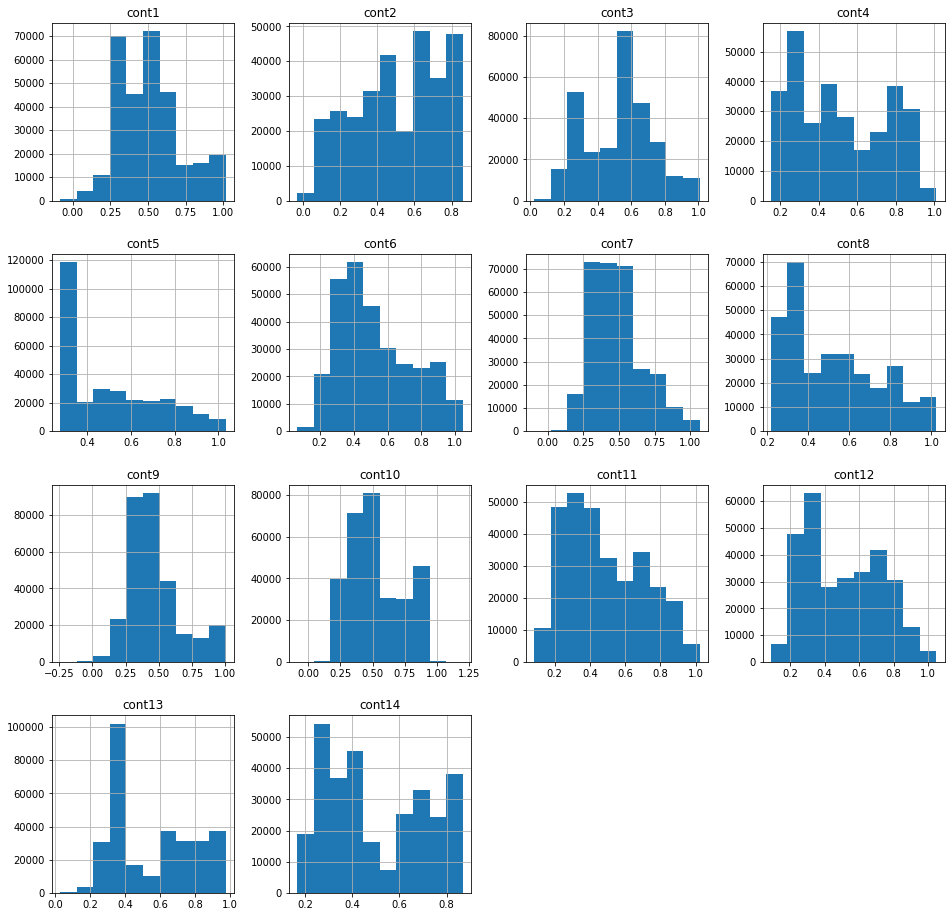

In [25]:
# Histograms for each attribute
df_features_train.hist(layout=(display_rows, display_columns))
plt.show()

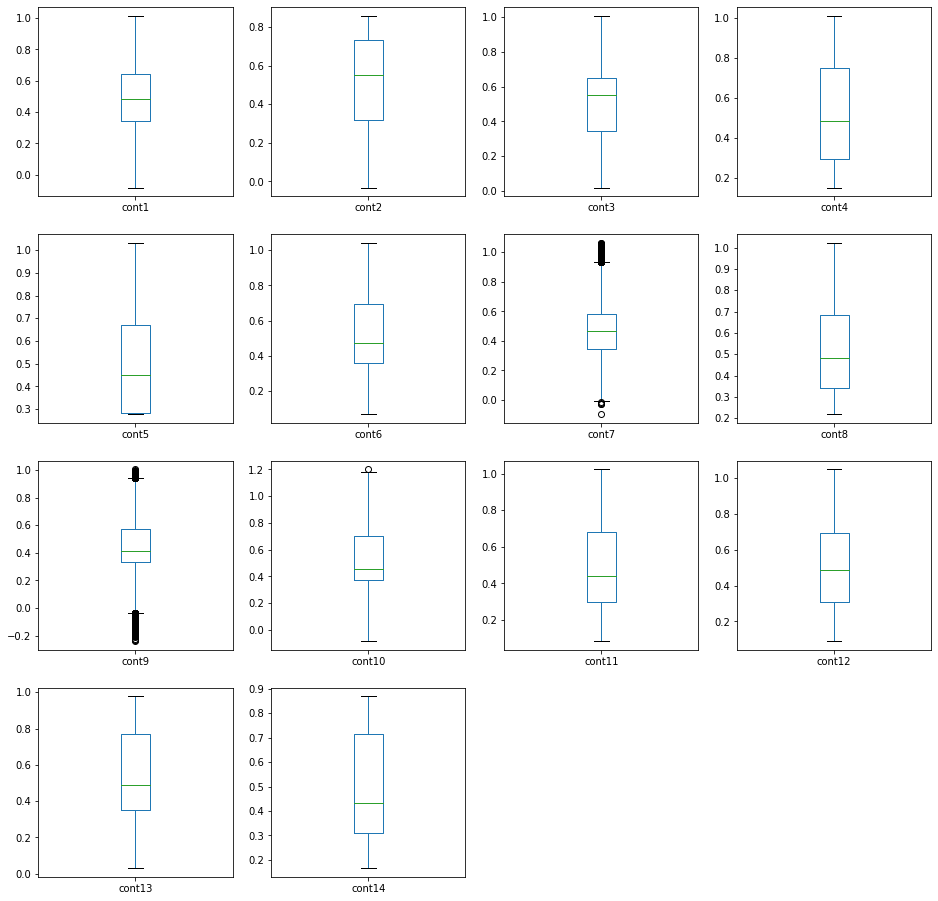

In [26]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

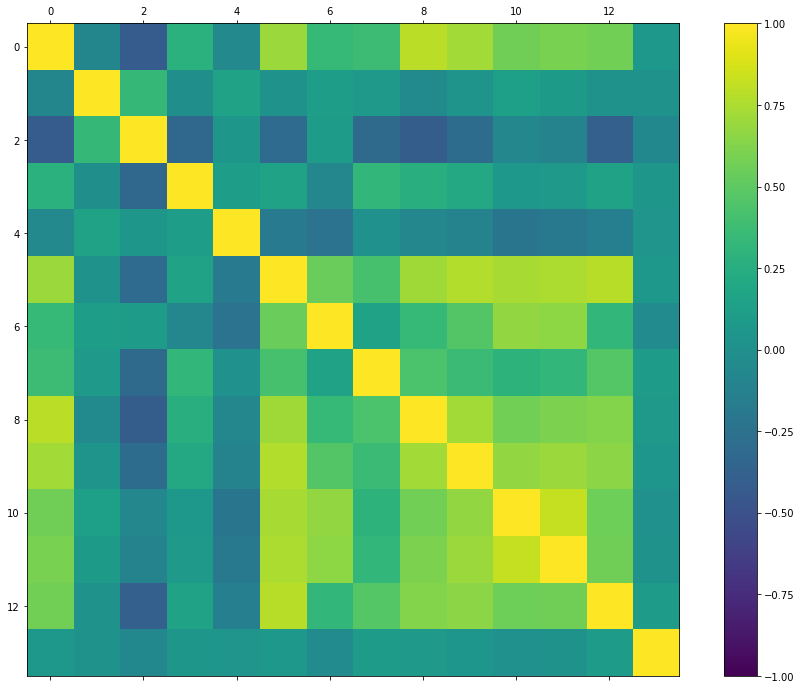

In [27]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = df_features_train.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [28]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [29]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [30]:
# Not applicable for this iteration of the project

### 3.b) Feature Scaling and Data Pre-Processing

In [31]:
# Not applicable for this iteration of the project

### 3.c) Training Data Balancing

In [32]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [33]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [34]:
# Finalize the training and validation datasets for the modeling activities
array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (300000, 14) array_target_train.shape: (300000,)


In [35]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [36]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [37]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
auto_model = StructuredDataRegressor(loss=DEFAULT_LOSS, metrics=DEFAULT_METRICS, max_trials=MAX_TRIALS,
                                     objective=kt.Objective("val_rmse", direction="min"), seed=RNG_SEED)
auto_model.fit(array_features_train, array_target_train, epochs=MAX_EPOCHS, validation_split=VAL_SET_SIZE, batch_size=BATCH_SIZE, verbose=2)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Trial 50 Complete [00h 03m 16s]
val_rmse: 0.7118636965751648

Best val_rmse So Far: 0.7084618806838989
Total elapsed time: 02h 33m 09s
INFO:tensorflow:Oracle triggered exit
Epoch 1/15
4688/4688 [==============================] - 17s 3ms/step - loss: 13.1673 - rmse: 2.4155
Epoch 2/15
4688/4688 [==============================] - 16s 3ms/step - loss: 1.6564 - rmse: 1.2858
Epoch 3/15
4688/4688 [==============================] - 16s 3ms/step - loss: 0.8598 - rmse: 0.9265
Epoch 4/15
4688/4688 [==============================] - 16s 3ms/step - loss: 0.5761 - rmse: 0.7589
Epoch 5/15
4688/4688 [==============================] - 16s 3ms/step - loss: 0.5242 - rmse: 0.7240
Epoch 6/15
4688/4688 [==============================] - 16s 3ms/step - loss: 0.5173 - rmse: 0.7192
Epoch 7/15
4688/4688 [==============================] - 16s 3ms/step - loss: 0.5159 - rmse: 0.7182
Epoch 8/15
4688/4688 [==============================] - 16s 3ms/step - loss: 0.5145 - rmse: 0.7173
Epoch 9/15
4688/4688 [============

In [38]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [39]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [40]:
final_model = auto_model.export_model()
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 14)                0         
_________________________________________________________________
normalization (Normalization (None, 14)                29        
_________________________________________________________________
dense (Dense)                (None, 256)               3840      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0     

### 6.b) Load Test Dataset and Prepare the Submission File

In [41]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jan/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

   id     cont1     cont2     cont3  ...    cont11    cont12    cont13    cont14
0   0  0.353600  0.738780  0.600939  ...  0.550540  0.699134  0.286864  0.364515
1   2  0.907222  0.189756  0.215531  ...  0.446475  0.449037  0.916964  0.513002
2   6  0.179287  0.355353  0.623972  ...  0.211913  0.222651  0.327164  0.827941
3   7  0.359385  0.181049  0.551368  ...  0.445276  0.518485  0.299028  0.598166
4  10  0.335791  0.682607  0.676481  ...  0.817721  0.805895  0.790591  0.249275

[5 rows x 15 columns]


In [42]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

   id
0   0
1   2
2   6
3   7
4  10


In [43]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

      cont1     cont2     cont3  ...    cont12    cont13    cont14
0  0.353600  0.738780  0.600939  ...  0.699134  0.286864  0.364515
1  0.907222  0.189756  0.215531  ...  0.449037  0.916964  0.513002
2  0.179287  0.355353  0.623972  ...  0.222651  0.327164  0.827941
3  0.359385  0.181049  0.551368  ...  0.518485  0.299028  0.598166
4  0.335791  0.682607  0.676481  ...  0.805895  0.790591  0.249275

[5 rows x 14 columns]


In [44]:
# Finalize the test dataset for the modeling testing
array_features_test = df_features_test.to_numpy()
print("array_features_test.shape: {}".format(array_features_test.shape))

array_features_test.shape: (200000, 14)


In [45]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[[8.080986 ]
 [7.7953553]
 [7.960967 ]
 ...
 [8.109383 ]
 [7.9833374]
 [7.875575 ]]


In [46]:
df_kaggle_submission['target'] = test_predictions
print(df_kaggle_submission.head())

   id    target
0   0  8.080986
1   2  7.795355
2   6  7.960967
3   7  8.043534
4  10  8.161701


In [47]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20210519-0254.csv


In [48]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [49]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 2:37:38.708650
